In [4]:
# 导入模块
import re

import findspark
from pyspark.sql.types import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list

from operator import add

from wordcloud import WordCloud, ImageColorGenerator
import jieba


In [8]:
# ======================== 初始化工作 =========================
# 指明SPARK_HOME
findspark.init("/Users/zhinushannan/environment/spark-3.2.1-bin-hadoop3.2")
# jieba加载自定义字典
jieba.load_userdict("./jieba_dict/dict.txt")
# 新建spark应用
spark = SparkSession.builder.master("local").appName("app").getOrCreate()
sc = spark.sparkContext
# 加载过滤字典
filter_list = []
with open("./jieba_dict/filter_dict.txt") as fp:
    filter_list.extend(fp.read().split("\n"))

22/06/03 23:48:44 WARN Utils: Your hostname, zhinushannan-deMacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.101.15.120 instead (on interface en0)
22/06/03 23:48:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/03 23:48:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# ============================== 数据清洗 ======================================

In [10]:
def filter_logs(line):
    """
    过滤掉“上传文件”、“成员加入”、“成员离开”三类事件
    :param line:
    :return:
    """
    match_upload = re.search(r"(^\[\S+ \S+]) \[INFO]: 群 (\S+) 内 ([\s\S]+) 上传了文件: ([\s\S]+)", line)
    match_member_add = re.search(r"(^\[\S+ \S+]) \[INFO]: 新成员 (\S+) 进入了群 ([\s\S]+)", line)
    match_member_leave = re.search(r"(^\[\S+ \S+]) \[INFO]: 成员 (\S+) 离开了群 ([\s\S]+)", line)

    if match_upload is None and match_member_add is None and match_member_leave is None:
        return True
    else:
        return False


def map_logs(line):
    """
    将过滤后的日志的发消息和收消息的事件构成新的RDD
    :param line:
    :return:
    """
    match_send = re.search(r"(^\[\S+ \S+]) \[INFO]: 发送群 (\S+) 的消息: ([\s\S]+)", line)
    match_get = re.search(r"(^\[\S+ \S+]) \[INFO]: 收到群 (\S+) 内 ([\s\S]+) 的消息: ([\s\S]+)", line)

    if match_send is None and match_get is None:
        return Row(
            time=None,
            group=None,
            user=None,
            message=line,
        )

    if match_send is not None:
        return Row(
            time=match_send.group(1),
            group=match_send.group(2),
            user="self",
            message=match_send.group(3),
        )
    if match_get is not None:
        return Row(
            time=match_get.group(1),
            group=match_get.group(2),
            user=match_get.group(3),
            message=match_get.group(4),
        )

def flat(l):
    """
    构建新自增列
    :param l:
    :return:
    """
    for k in l:
        if not isinstance(k, (list, tuple)):
            yield k
        else:
            yield from flat(k)

def map_remove_message_some(line):
    """
    移除message中除face以外所有的CQ
    :param line:
    :return:
    """
    message = str(line["_4"])
    # 移除 message_id
    message = message[0:message.rfind("(")]
    # 移除 回复 事件
    result = re.compile(r"(\[CQ:\w+,[\w!@#$%^…￥&()_=+-/*\"'‘’“”,.<>?！？《》、：:|\\]+])").findall(message)
    for i in result:
        if "[CQ:face," in i:
            continue
        message = message.replace(i, "")
    message = message.replace(" ", "")
    return Row(
        time=line["_1"],
        group=line["_2"],
        user=line["_3"],
        message=message
    )


def filter_message(line):
    user = str(line["user"])
    message = str(line["message"])

    return user != "self" and len(message) != 0 and "[CQ:json," not in message

In [11]:
# 读取文件
files = sc.textFile("./logs/2022-05-26.log")
for i in range(0, len(files.collect())):
    print(i, files.collect()[i])

0 [2022-05-26 00:10:00] [INFO]: 收到群 20Z计科通知群(540450397) 内 Q群管家(2854196310) 的消息: [CQ:at,qq=all] 熬夜追剧打游戏，趁机打个健康打卡୧⍤⃝
1 ——来自群管理员（1772203969）的编辑 (1432080297) 
2 [2022-05-26 00:25:26] [INFO]: 收到群 新蜂生活超市(854452883) 内 懒羊羊(1834808612) 的消息: 老板 我能不能拿红豆味的换原味的/吃糖 (273820844) 
3 [2022-05-26 00:25:56] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: [CQ:image,file=cb80e6329653f24f8fa22aa7ecd7d1de.image,subType=1] (-1909016305) 
4 [2022-05-26 00:26:25] [INFO]: 收到群 新蜂生活超市(854452883) 内 千里眼(80000000) 的消息: 我偷个图 (-114194023) 
5 [2022-05-26 00:27:39] [INFO]: 收到群 新蜂生活超市(854452883) 内 懒羊羊(1834808612) 的消息: [CQ:image,file=46f9a81263387dc809c6117b49e4206a.image,subType=7] (1614338083) 
6 [2022-05-26 00:42:16] [INFO]: 收到群 新蜂生活超市(854452883) 内 нёιιö(940717071) 的消息: [CQ:image,file=ee153729561d155db93a8e75f7bbd80e.image,subType=1] (390064309) 
7 [2022-05-26 00:42:47] [INFO]: 收到群 新蜂生活超市(854452883) 内 нёιιö(940717071) 的消息: [CQ:image,file=7e099be23d1be965050a10c168a88d43.image,subType=1] (-2021591772) 
8 [2022-05-2

72 尚 ... (-1453655010) 
73 [2022-05-26 08:32:57] [INFO]: 发送群 21数据官方群(673433432) 的消息: 健康打卡自动提醒
74 尚 ... (-1904521437) 
75 [2022-05-26 08:33:08] [INFO]: 发送群 21软件2班(626284843) 的消息: 健康打卡自动提醒
76 尚 ... (-1694548377) 
77 [2022-05-26 08:33:19] [INFO]: 发送群 21软件3班通知群(684039593) 的消息: 健康打卡自动提醒
78 尚 ... (862768965) 
79 [2022-05-26 08:33:54] [INFO]: 收到群 新蜂生活超市(854452883) 内 观音菩萨(80000000) 的消息: 🙏 (491727974) 
80 [2022-05-26 08:41:26] [INFO]: 收到群 21软件3班通知群(684039593) 内 夏康宁15150083010(373505118) 的消息: [CQ:image,file=980ea464a9b665fa3b9447ae55c0d6ab.image,subType=0] (-1436180737) 
81 [2022-05-26 08:41:26] [INFO]: 收到群 21软件3班通知群(684039593) 内 夏康宁15150083010(373505118) 的消息: 核酸地点为教五楼与实验楼连廊，教五楼南侧。 (-580735383) 
82 [2022-05-26 08:41:50] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: [CQ:image,file=d38fb49b210d9670dafaf4fb5ce15d42.image,subType=0] (-1645845385) 
83 [2022-05-26 08:41:51] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: 核酸地点为教五楼与实验楼连廊，教五楼南侧。 (82785741) 
84 [2022-

158 [2022-05-26 10:20:02] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 兜兜里藏着糖(2912906799) 的消息: [CQ:image,file=d9fcbf6cb511a8a729cee9157905df8c.image,subType=0] (1287228461) 
159 [2022-05-26 10:21:17] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 一只球球(435698356) 的消息: 拼屈臣氏牙线棒 六块多一盒50支 [CQ:image,file=03f3d22c2c27d95d4174ff3b67cd823c.image,subType=0] (1002355899) 
160 [2022-05-26 10:22:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 凉城小白(617207568) 的消息: 出蓝牙耳机，10元 (-1425956566) 
161 [2022-05-26 10:22:15] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 凉城小白(617207568) 的消息: [CQ:image,file=da8bfe69c5128831f90b2c8cab2485cb.image,subType=0] (-603549252) 
162 [2022-05-26 10:23:27] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 宏宝莱 (-1913638409) 
163 [2022-05-26 10:23:29] [INFO]: 收到群 新蜂生活超市(854452883) 内 小po(2297728680) 的消息: 好甜 (-315115502) 
164 [2022-05-26 10:23:57] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 肉肉(3270682323) 的消息: f有打印吗 (-1128196007) 
165 [2022-05-26 10:24:02] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 肉肉(3270682323) 的消息: [CQ:fac

247 尚未打卡的同学如下：
248 [CQ:at,qq=1501913223] 	
249 已打卡的同学请忽略此条消息
250 11:32:30 (-2063772362) 
251 [2022-05-26 11:32:45] [INFO]: 发送群 21软件2班(626284843) 的消息: 健康打卡已完成！
252 1 ... (66482141) 
253 [2022-05-26 11:32:52] [INFO]: 收到群 20软件2班官方群(953152455) 内 健康打卡小助手(3528275423) 的消息: 健康打卡自动提醒
254 尚未打卡的同学如下：
255 [CQ:at,qq=421712537] 	[CQ:at,qq=183268352] 	[CQ:at,qq=960919037] 	
256 已打卡的同学请忽略此条消息
257 11:32:46 (-1251317180) 
258 [2022-05-26 11:34:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 ☀(501741082) 的消息: 洗发水30r 沐浴露20r 吹风机小功率15r[CQ:image,file=438040874f299d05d6707a329ab06358.image,subType=0][CQ:image,file=188e69724a20c4b9cbc9f0033a242075.image,subType=0][CQ:image,file=5c98ccd0993bb37d24cf9e8c191d31b1.image,subType=0] (-1746121830) 
259 [2022-05-26 11:36:31] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 B组团(951659601) 的消息: 出物联网专业书 (-521438452) 
260 [2022-05-26 11:36:31] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 B组团(951659601) 的消息: [CQ:image,file=a006b8cd71b0806be955b030749dae6d.image,subType=0] (2044865206) 
261 [2022-05-26 

315 [2022-05-26 12:53:38] [INFO]: 收到群 20Z计科通知群(540450397) 内 周曾贤 19852067895(2419785771) 的消息: 主要是宿舍床铺都没有，没洗没晒，要过去还得带铺盖的，带过去过不了几天就又要带回来 (-1524409379) 
316 [2022-05-26 12:53:50] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: 下午4:30前我导出名单上报  有变动的话大家两个在线文档更新 (899434060) 
317 [2022-05-26 12:54:48] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: [CQ:at,qq=2419785771] 行李都不在的话 可以不过来  委托同学协助办理其他事情一样的 (1117484762) 
318 [2022-05-26 12:54:59] [INFO]: 收到群 20智能科学与技术(1014806242) 内 数电-张静宇老师(732257229) 的消息: [CQ:json,data={"app":"com.tencent.structmsg"&#44;"config":{"ctime":1653540898&#44;"forward":true&#44;"token":"32cbcb52241d321c05fb2e30f9e2cb1e"&#44;"type":"normal"}&#44;"desc":"新闻"&#44;"extra":{"app_type":1&#44;"appid":101458937&#44;"uin":732257229}&#44;"meta":{"news":{"action":""&#44;"android_pkg_name":""&#44;"app_type":1&#44;"appid":101458937&#44;"ctime":1653540898&#44;"desc":"腾讯文档-在线表格"&#44;"jumpUrl":"https://docs.qq.com/sheet/DTnpoamRtS0hyVFVX"&#44;"preview":"https://docs.idq

409 尚 ... (1529465222) 
410 [2022-05-26 15:01:33] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 陌年(1205578199) 的消息: [CQ:image,file=e0ad743dd99f90bf634c8e1122bef407.image,subType=0] (1939009125) 
411 [2022-05-26 15:01:39] [INFO]: 收到群 新蜂生活超市(854452883) 内 增长天王(80000000) 的消息: 老板，超市有娃哈哈纯净水吗 (-553526640) 
412 [2022-05-26 15:02:47] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 接代抄 代拿快递 abcd(2413544749) 的消息: [CQ:image,file=62ccbef9bac0b3b631f18b086d7c32d7.image,subType=0] (-302613562) 
413 [2022-05-26 15:05:43] [INFO]: 收到群 新蜂生活超市(854452883) 内 增长天王(80000000) 的消息: [CQ:at,qq=105070597]  (-1475941882) 
414 [2022-05-26 15:06:24] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: [CQ:reply,id=-553526640]现在没有进货，要自己搬上楼，太累了 (823114684) 
415 [2022-05-26 15:07:25] [INFO]: 收到群 新蜂生活超市(854452883) 内 增长天王(80000000) 的消息: 过几天能有吗😂 (1174965034) 
416 [2022-05-26 15:07:40] [INFO]: 收到群 新蜂生活超市(854452883) 内 新蜂生活超市(105070597) 的消息: [CQ:image,file=a32aafd28d5f5c4d53a9e97914638968.image,subType=7] (-664002935) 
417 [2022-05-26 15:07:48] 

480 [2022-05-26 16:18:09] [INFO]: 收到群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 的消息: 文件名以宿舍号+自己姓名 命名 (158444796) 
481 [2022-05-26 16:18:10] [INFO]: 群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 上传了文件: 附件2：江苏师范大学科文学院学生返校申报表.docx 
482 [2022-05-26 16:19:08] [INFO]: 收到群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 的消息: 附件1 5在群文件的“毕业生返校申报材料附件”（原名：附件）文件夹内 (-411054640) 
483 [2022-05-26 16:19:25] [INFO]: 收到群 20Z计科通知群(540450397) 内 潜艺筝 17712117344(1772203969) 的消息: 附件1、5在群文件的“毕业生返校申报材料附件”（原名：附件）文件夹内，请自行下载。 (-1871119034) 
484 [2022-05-26 16:20:29] [INFO]: 收到群 新蜂生活超市(854452883) 内 白衣秀士(80000000) 的消息: [CQ:at,qq=105070597] 有没有海河？ (1447186029) 
485 [2022-05-26 16:20:55] [INFO]: 收到群 新蜂生活超市(854452883) 内 张不屈(3059422105) 的消息: ➕1 (558202619) 
486 [2022-05-26 16:32:07] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 兜兜里藏着糖(2912906799) 的消息: 出 (-2074081755) 
487 [2022-05-26 16:32:08] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 兜兜里藏着糖(2912906799) 的消息: [CQ:image,file=cfc4287a736ae458027819b4ea9b6fe6.image,subType

546 [2022-05-26 17:52:43] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: 欧科互动网络科技（北京）有限公司春招补录发车！冲！还有机会！
547 
548 【宣讲会时间】2022年5月26日（周四）18:00
549 【宣讲会链接】https://yqy.h5.xeknow.com/s/1spUHS
550 【简历投递链接】https://wj.qq.com/s2/10272108/e6c0/
551 【招聘入群链接，需手机端打开】http://url.qunjifen.com/J4XNk
552 感兴趣的同学可以加群了解详情！！！
553 【企业名称】欧科互动网络科技（北京）有限公司
554 【公司简介】欧科是全球领先的区块链企业！亦是中国本土成立时间最早的区块链企业之一！2013年成立以来，一直致力于区块链技术的研发与商用，现已发展成全球化的大型区块链技术与服务提供商。总部设在中国北京，在美国、欧洲、日本等10余个国家和地区设有分公司或办公室，业务覆盖全球180余个国家和地区，服务世界各地的用户超过5000万！
555 【招聘岗位】JAVA开发工程师
556 【需求专业】计算机及电子信息相关专业，有互联网大厂实习经验，有区块链项目经验的学生优先
557 【薪资待遇】月薪2w-2.5w，带薪休假，下午茶，季度生日会，补充医疗，员工健身房，图书馆，年度体检，节日活动和礼品，团建活动
558 【工作地点】北京海淀上地 (236742885) 
559 [2022-05-26 17:52:57] [INFO]: 收到群 20Z计科通知群(540450397) 内 辅导员——王群(953060053) 的消息: 深圳市宝创森那美汽车销售服务有限公司春招补录发车！冲！还有机会！
560 
561 【宣讲会时间】2022年5月26日（周四）19:00
562 【宣讲会链接】https://yqy.h5.xeknow.com/s/4qEX9L
563 【简历投递链接】https://wj.qq.com/s2/10257475/8223/
564 【招聘入群链接，需手机端打开】http://url.qunjifen.com/JtY4W
565 
566 感兴趣的同学可以加群了解详情！！！


638 [2022-05-26 18:59:35] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 Lee.(1526210233) 的消息: 收台灯 (-827388391) 
639 [2022-05-26 19:01:35] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 c组团  自取(3310931602) 的消息: 收一个投影仪 (-1180156273) 
640 [2022-05-26 19:02:04] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 B组团(951659601) 的消息: 出口罩，上面两种三块钱一包十片，独立包装黑色口罩三块钱十二片[CQ:image,file=ea116145590db52554c6a4ef3ec7e2d8.image][CQ:image,file=17de3254dbbc37bb615fc100aacd33ad.image][CQ:image,file=f60583f44c17d7686013886d549207fa.image] (-646989974) 
641 [2022-05-26 19:03:57] [INFO]: 收到群 新蜂生活超市(854452883) 内 栀夏(2598734761) 的消息: 老板，有抹茶吐司吗？[CQ:at,qq=105070597] (2139899724) 
642 [2022-05-26 19:06:17] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 王者代打 B组团代拿快递(643065771) 的消息: [CQ:image,file=9d61b541925b403c96394a1ca6a13767.image,subType=0] (-1368881156) 
643 [2022-05-26 19:06:19] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 王者代打 B组团代拿快递(643065771) 的消息: 出盲盒 (929158726) 
644 [2022-05-26 19:06:56] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 求冰墩墩发夹(1608791108) 的消息: 试穿过 5r出  黑色的

706 [2022-05-26 20:57:17] [INFO]: 收到群 21数据官方群(673433432) 内 班主任-周俊(1027418356) 的消息: [CQ:reply,id=-1521083168][CQ:at,qq=2047859253] [CQ:at,qq=2047859253] http://10.110.222.1/index.php?v=show&amp;cid=1&amp;id=3375 (-1298750061) 
707 [2022-05-26 20:58:53] [INFO]: 收到群 潘安湖二手物品转卖群(949682820) 内 B组团(951659601) 的消息: [CQ:image,file=8250537a990928e572a31e5cbe8e743a.image,subType=0] (-1665573549) 
708 [2022-05-26 21:00:14] [INFO]: 收到群 21数据官方群(673433432) 内 班主任-周俊(1027418356) 的消息: 评教网址：http://10.110.240.221/jsxsd。[CQ:at,qq=all] (-980314875) 
709 [2022-05-26 21:00:44] [INFO]: 收到群 科文学院21Z计科(913765781) 内 63 学委 赵猛(2912580980) 的消息: 【友情提醒】：截至目前，各教师学评教参评率约为40%，学评教截止日期为5月28日0点，本次不参与学评教的学生无法进行下学期公共选修课选课，请各学委督促未进行学评教的学生进行评教。@全体成员  (774199548) 
710 [2022-05-26 21:00:45] [INFO]: 收到群 科文学院21Z计科(913765781) 内 63 学委 赵猛(2912580980) 的消息: 评教网址：http://10.110.240.221/jsxsd。@全体成员 (1495427178) 
711 [2022-05-26 21:01:19] [INFO]: 收到群 20智能科学与技术(1014806242) 内 54  郑宁宁(2872124414) 的消息: 评教网址：http://10.110.240.221/jsxsd。@全体成员 (1157

773 [2022-05-26 23:05:41] [INFO]: 收到群 新蜂生活超市(854452883) 内 青毛狮王(80000000) 的消息: 还是富二代 (-1548466974) 
774 [2022-05-26 23:06:17] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: [CQ:image,file=79cacef3b51fa0d31cc58cde17df0141.image,subType=1] (-1463958804) 
775 [2022-05-26 23:06:29] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: [CQ:image,file=4300d768000597e4d95499be3e79a931.image,subType=0] (833917782) 
776 [2022-05-26 23:06:37] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: 明日核酸检测，名单如上，根据教务提供的名单，参加计算机考试需要48小时内核算检测阴性报告，全部纳入明日核酸检测人员名单，18级如学生放弃考试请自行忽略。参加考试但不在名单上的学生请及时与我联系。 (1186177984) 
777 [2022-05-26 23:07:13] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: [CQ:at,qq=2796904898]  (-703807919) 
778 [2022-05-26 23:07:19] [INFO]: 收到群 20软件1班官方群(927974093) 内 夏康宁15150083010(373505118) 的消息: 教五楼南侧 (-1593078073) 
779 [2022-05-26 23:07:28] [INFO]: 收到群 20软件1班官方群(927974093) 内 班长吴思鹏(2796904898) 的消息: 收到 (-1043593438) 
780 [2022-0

In [19]:
# 数据清洗：将消息日志转为dataframe

logs = files.filter(filter_logs).map(map_logs)
logs_df = logs.toDF()
print(type(logs_df))
logs_df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+------------------------+-----------------------+-----------------------------------+
|                time|                   group|                   user|                            message|
+--------------------+------------------------+-----------------------+-----------------------------------+
|[2022-05-26 00:10...|20Z计科通知群(540450397)|    Q群管家(2854196310)|             [CQ:at,qq=all] 熬夜...|
|                null|                    null|                   null|        ——来自群管理员（17722039...|
|[2022-05-26 00:25...| 新蜂生活超市(854452883)|     懒羊羊(1834808612)|老板 我能不能拿红豆味的换原味的/...|
|[2022-05-26 00:25...| 新蜂生活超市(854452883)|新蜂生活超市(105070597)|               [CQ:image,file=cb...|
|[2022-05-26 00:26...| 新蜂生活超市(854452883)|       千里眼(80000000)|             我偷个图 (-114194023) |
|[2022-05-26 00:27...| 新蜂生活超市(854452883)|     懒羊羊(1834808612)|               [CQ:image,file=46...|
|[2022-05-26 00:42...| 新蜂生活超市(854452883)|       нёιιö(9407170

In [13]:
"""  合并换行的消息  """
logs_rdd = logs_df.rdd.zipWithIndex()
logs_rdd = logs_rdd.map(lambda x: list(flat(x)))
i = 0
logs_list = logs_rdd.collect()
while i < len(logs_list):
    if i + 1 < len(logs_list) and logs_list[i + 1][0] is None:
        logs_list[i][3] += logs_list[i + 1][3]
        logs_list.pop(i + 1)
    else:
        i += 1

logs_table = spark.createDataFrame(data=logs_list).rdd.map(map_remove_message_some).filter(filter_message).toDF()
logs_table.show()

+--------------------+------------------------------+-------------------------+-------------------------------------+
|                time|                         group|                     user|                              message|
+--------------------+------------------------------+-------------------------+-------------------------------------+
|[2022-05-26 00:10...|      20Z计科通知群(540450397)|      Q群管家(2854196310)| 熬夜追剧打游戏，趁机打个健康打卡୧...|
|[2022-05-26 00:25...|       新蜂生活超市(854452883)|       懒羊羊(1834808612)|  老板我能不能拿红豆味的换原味的/吃糖|
|[2022-05-26 00:26...|       新蜂生活超市(854452883)|         千里眼(80000000)|                             我偷个图|
|[2022-05-26 00:44...|       新蜂生活超市(854452883)|           财神(80000000)|                     老板，我来送财了|
|[2022-05-26 00:45...|       新蜂生活超市(854452883)|         нёιιö(940717071)|                             给我出来|
|[2022-05-26 00:45...|       新蜂生活超市(854452883)|         нёιιö(940717071)|                                 大黄|
|[2022-05-26 00:46...|       新蜂生活超市

In [14]:
# ============================== 词云统计 ======================================

In [15]:
def map_remove_face_cq(line):
    message = str(line["message"])
    result = re.compile(r"(\[CQ:face,id=(\d+)])").findall(str(message))
    for i in result:
        message.replace(i[0], "")
    return message


def map_jieba(line):
    jieba_result = jieba.cut(line)
    result = []
    for i in jieba_result:
        result.append(i)
    jieba_result = jieba.cut(line, cut_all=True)
    all = []
    for i in jieba_result:
        all.append(i)
    return Row(
        raw=line,
        # cut_hmm=str(result)[1:-1],
        # cut_all=str(all)[1:-1],
        cut_hmm=result,
        cut_all=all,
        id=1
    )


def filter_dict(line):
    key = line[0]
    if key in filter_list:
        return False
    return True

In [16]:
# 筛选对应群聊、删除不必要的列
message_df = logs_table.rdd.filter(
    lambda message: message["group"] == "潘安湖二手物品转卖群(949682820)" or message["group"] == "新蜂生活超市(854452883)").toDF().drop(
    "time").drop("group").drop("user")
# 删除消息中的表情，使用jieba分词
message_df = message_df.rdd.map(map_remove_face_cq).map(map_jieba).toDF()
message_df.show()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.542 seconds.                                   (0 + 1) / 1]
Prefix dict has been built successfully.
Building prefix dict from the default dictionary ...                            
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache


+-------------------------------------+----------------------------+------------------------------+---+
|                                  raw|                     cut_hmm|                       cut_all| id|
+-------------------------------------+----------------------------+------------------------------+---+
|  老板我能不能拿红豆味的换原味的/吃糖|[老板, 我能, 不能, 拿, 红...|   [老板, 我, 能, 不能, 拿,...|  1|
|                             我偷个图|              [我, 偷个, 图]|              [我, 偷, 个, 图]|  1|
|                     老板，我来送财了|[老板, ，, 我来, 送, 财, 了]|    [老板, ，, 我, 来, 送, ...|  1|
|                             给我出来|              [给, 我, 出来]|                [给, 我, 出来]|  1|
|                                 大黄|                      [大黄]|                        [大黄]|  1|
|                                 干嘛|                      [干嘛]|                        [干嘛]|  1|
|                             拍我干啥|            [拍, 我, 干, 啥]|              [拍, 我, 干, 啥]|  1|
|                         收抽纸或卷纸|        [收, 抽纸, 或, 卷纸]|      

Loading model cost 0.516 seconds.
Prefix dict has been built successfully.


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/1q/53p30k9s7x7517km16kh2__00000gn/T/jieba.cache
Loading model cost 0.521 seconds.                                   (0 + 1) / 1]
Prefix dict has been built successfully.


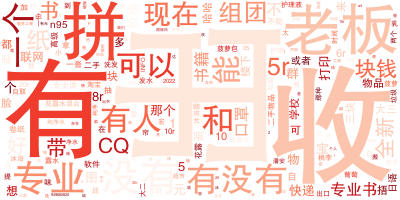

In [18]:
# 将全模式分词的结果合并成一个list
message_list = message_df.groupby("id").agg(collect_list('cut_all').alias('cut_all_list')).rdd.collect()
words = str(message_list[0]["cut_all_list"]).replace("[", "").replace("]", "").replace("'", "").split(", ")
# 统计词频
words_df = sc.parallelize(words).map(lambda x: (x, 1)).reduceByKey(add).toDF(schema=["word", "frequency"])
word_frequency = words_df.rdd.map(lambda word: (word["word"], word["frequency"])).filter(filter_dict).collect()
word_frequency_dict = {}
for i in word_frequency:
    word_frequency_dict[i[0]] = i[1]

# 生成词云
wc = WordCloud(font_path="./fonts/FangZhengHeiTiJianTi-1.ttf",
               background_color='#FFFFFF', colormap="Reds", repeat=True)

wc.fit_words(word_frequency_dict)
wc.to_image()